In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Feature process

In [2]:
!pip install speechpy

In [3]:
import scipy.io.wavfile as wav
import numpy as np 
from speechpy.feature import mfcc
import PIL.Image as img
import os

# dataDirName = "/home/huong/SoundCalculationData"
dataDirName = '/content/drive/MyDrive/PAPER HN/Snoring problem/Data'
# dataDirName = "/content/drive/MyDrive/Data"
resSnoreDir = dataDirName + "/MFCCData_m/Snoring"
resNonSnoreDir = dataDirName + "/MFCCData_m/NonSnoring"

pathSnoring = dataDirName + "/Calculation Data /Snoring"
pathNonSnoring = dataDirName + "/Calculation Data /Non-snoring"  

In [4]:

if not os.path.exists(resSnoreDir):
    os.makedirs(resSnoreDir)


if not os.path.exists(resNonSnoreDir):
    os.makedirs(resNonSnoreDir)

for filename in os.listdir(pathSnoring):
    if filename.endswith('.wav'):
        (fs, sig) = wav.read(pathSnoring + "/" + filename)
        sig = np.max(sig, axis=1) if sig.ndim == 2 else sig # Librosa If multi-channel audio input y is provided, the MFCC calculation will depend on the peak loudness (in decibels) across all channels. The result may differ from independent MFCC calculation of each channel.
        #extract mfcc features
        
        mfcc_feat = mfcc(sig, sampling_frequency=fs, frame_length=0.030, frame_stride=0.01,
         num_cepstral=32, num_filters=32, fft_length=512, low_frequency=0, high_frequency=None)

        outputFile = resSnoreDir + "/" + os.path.splitext(filename)[0] + ".npy"
        np.save(outputFile, mfcc_feat)

for filename in os.listdir(pathNonSnoring):
    if filename.endswith('.wav'):
        (fs, sig) = wav.read(pathNonSnoring + "/" + filename)
        sig = np.max(sig, axis=1) if sig.ndim == 2 else sig
        #extract mfcc features
        mfcc_feat = mfcc(sig, sampling_frequency=fs, frame_length=0.030, frame_stride=0.01,
         num_cepstral=32, num_filters=32, fft_length=512, low_frequency=0, high_frequency=None)

        outputFile = resNonSnoreDir + "/" + os.path.splitext(filename)[0] + ".npy"
        np.save(outputFile, mfcc_feat)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: WavFileWarning: Chunk (non-data) not understood, skipping it.


# Model

In [5]:
import os
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


In [6]:
featureDirName = '/content/drive/MyDrive/PAPER HN/Snoring problem/Data/MFCCData_m'
# featureDirName = '/content/drive/MyDrive/Data/MFCCData_m'
pathSnoring = featureDirName + '/Snoring/'
pathNonSnoring = featureDirName + '/NonSnoring/'

listSnoreFile = os.listdir(pathSnoring)
listNonSnoreFile = os.listdir(pathNonSnoring)

In [7]:
train_image = []
label = []

# num_feature = 0
for id in range(0, len(listSnoreFile)):
  # if listSnoreFile[id].endswith('.npy'):
  filePath = os.path.join(pathSnoring, listSnoreFile[id])
  img = np.load(filePath)
  train_image.append(img)
    # num_feature += 1
# label.extend([1] * num_feature)
label.extend([1] * len(listSnoreFile))

# num_feature = 0
for id in range(0, len(listNonSnoreFile)):
  # if listNonSnoreFile[id].endswith('.npy'):
  filePath = os.path.join(pathNonSnoring, listNonSnoreFile[id])
  img = np.load(filePath)
  train_image.append(img)
    # num_feature += 1
# label.extend([0] * num_feature)
label.extend([0] * len(listNonSnoreFile))

X, y = np.array(train_image), np.array(label)

In [8]:
print(X.shape)

(1000, 97, 32)


In [9]:
def split_sequence(sequence, timesteps, stride=5):
    result = []
    for i in range(0, len(sequence) - timesteps + 1, stride):
        result.append(sequence[i:i + timesteps])
    return np.array(result)


timesteps = 16
# X = np.expand_dims(np.concatenate((split_sequence(X[:500], timesteps), split_sequence(X[500:], timesteps)), axis=0), axis=4)
# y = np.array([0] * (X.shape[0] // 2) + [1] * (X.shape[0] // 2))

X = np.expand_dims(np.concatenate([np.expand_dims(split_sequence(x, timesteps=timesteps, stride=timesteps), axis=0) for x in X], axis=0), axis=4)

n_sequence = X.shape[1]
print(X.shape, y.shape)

(1000, 6, 16, 32, 1) (1000,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
test = X_test
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.222)

In [11]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.layers import TimeDistributed,  LSTM

# CNN + LSTM
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size = (3,3), padding = "same", activation="relu", input_shape = (timesteps,32, 1)))
cnn.add(Conv2D(32, kernel_size = (3,3), padding = "valid", activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(64, kernel_size = (3,3), padding = "same", activation="relu"))
cnn.add(Conv2D(64, kernel_size = (3,3), padding = "valid", activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(n_sequence, timesteps, 32, 1)))
model.add(LSTM(2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

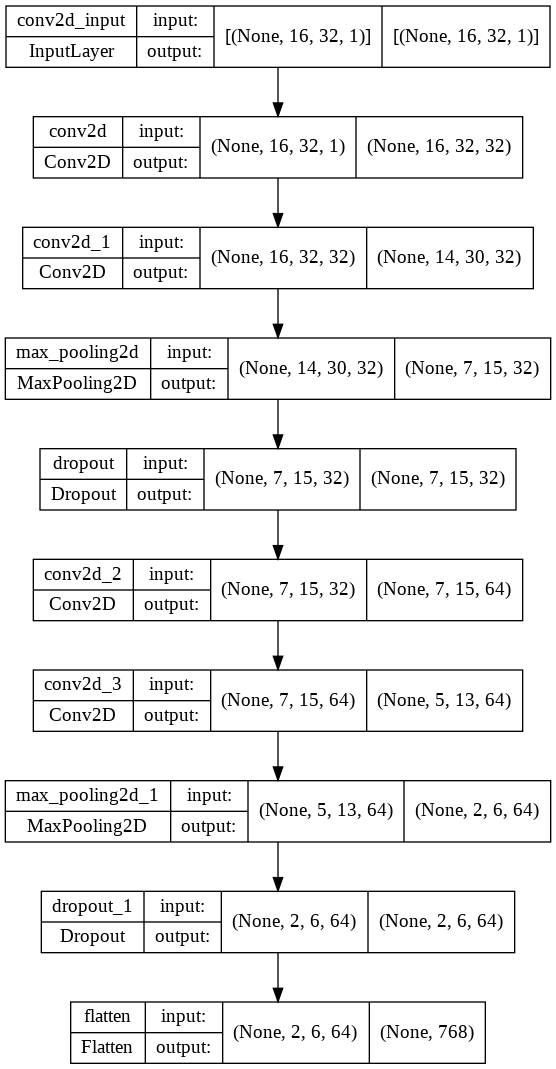

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

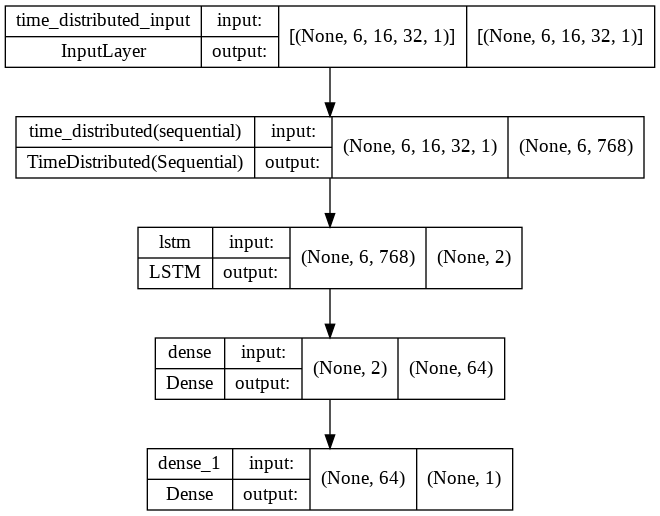

In [13]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
## RNN ONLY MODEL
model = Sequential()
model.add(LSTM(2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.compile(optimizer='adam',  loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(X_train,  y_train, epochs=100, validation_data = (X_validate, y_validate))

Epoch 1/100
22/22 [==============================] - 12s 398ms/step - loss: 0.6957 - accuracy: 0.4700 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/100
22/22 [==============================] - 8s 363ms/step - loss: 0.6928 - accuracy: 0.5029 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 3/100
22/22 [==============================] - 8s 364ms/step - loss: 0.6894 - accuracy: 0.5029 - val_loss: 0.6810 - val_accuracy: 0.5000
Epoch 4/100
22/22 [==============================] - 8s 365ms/step - loss: 0.6574 - accuracy: 0.5900 - val_loss: 0.6197 - val_accuracy: 0.7900
Epoch 5/100
22/22 [==============================] - 8s 362ms/step - loss: 0.5907 - accuracy: 0.8286 - val_loss: 0.5546 - val_accuracy: 0.9100
Epoch 6/100
22/22 [==============================] - 8s 365ms/step - loss: 0.5379 - accuracy: 0.8943 - val_loss: 0.5072 - val_accuracy: 0.9550
Epoch 7/100
22/22 [==============================] - 8s 364ms/step - loss: 0.4888 - accuracy: 0.9400 - val_loss: 0.4689 - val_accuracy: 0.950

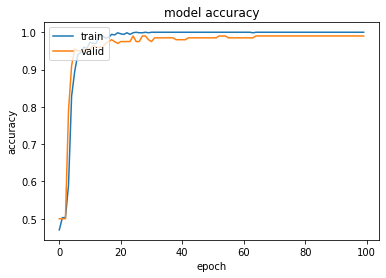

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

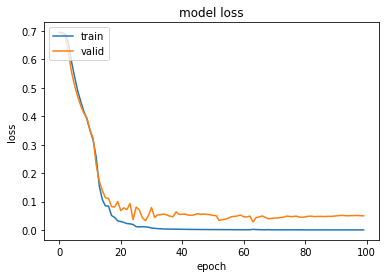

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [22]:
prediction = model.predict(test)
print(prediction)

[[9.9979615e-01]
 [9.9979675e-01]
 [3.3563375e-04]
 [9.9979681e-01]
 [3.3557415e-04]
 [9.9979651e-01]
 [3.3557415e-04]
 [3.3554435e-04]
 [3.3730268e-04]
 [9.9979675e-01]
 [9.9979484e-01]
 [9.9979120e-01]
 [3.3599138e-04]
 [9.9979675e-01]
 [9.9979687e-01]
 [3.4022331e-04]
 [3.3563375e-04]
 [9.9979675e-01]
 [3.3572316e-04]
 [9.9979681e-01]
 [3.3602118e-04]
 [3.3557415e-04]
 [3.3551455e-04]
 [9.9979681e-01]
 [2.2172061e-01]
 [9.9979669e-01]
 [9.9979317e-01]
 [9.9979657e-01]
 [9.9979675e-01]
 [3.3697486e-04]
 [9.9979675e-01]
 [9.9978423e-01]
 [9.9979681e-01]
 [3.3563375e-04]
 [3.3569336e-04]
 [3.3754110e-04]
 [9.9979401e-01]
 [9.9979645e-01]
 [3.3831596e-04]
 [3.3566356e-04]
 [9.9979639e-01]
 [9.9977392e-01]
 [3.3983588e-04]
 [9.9979681e-01]
 [3.3703446e-04]
 [8.0174422e-01]
 [3.3620000e-04]
 [3.3658743e-04]
 [1.6487896e-02]
 [9.9979681e-01]
 [9.9979663e-01]
 [3.3611059e-04]
 [3.3637881e-04]
 [9.9979681e-01]
 [9.9979675e-01]
 [9.9979579e-01]
 [9.9916595e-01]
 [3.3563375e-04]
 [9.9979615e-0

In [26]:
from google.colab import files
model.save('mix_model.h5')
files.download('mix_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>